In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# 0.) Clean the Apple Data to get a quarterly series of EPS.

In [6]:
y = pd.read_csv("AAPL_quarterly_financials.csv")

In [7]:
y.index = y.name

In [11]:
y = pd.DataFrame(y.loc["BasicEPS", :]).iloc[2:, :]

In [12]:
y.index = pd.to_datetime(y.index)

In [13]:
#Assumption nulls are 0s. need to investigate
y.fillna(0.).sort_index()

,BasicEPS
1985-09-30,0.0
1985-12-31,0.004
1986-03-31,0.002
1986-06-30,0.002
1986-09-30,0.0
...,...
2022-09-30,1.29
2022-12-31,1.89
2023-03-31,1.53
2023-06-30,1.27


# 3.) Come up with 6 search terms you think could nowcast earnings. (Different than the ones I used) Add in 3 terms that that you think will not Nowcast earnings. Pull in the gtrends data. Clean it to have a quarterly average.

In [2]:
from pytrends.request import TrendReq

In [21]:
import time

In [22]:
# Create pytrends object
pytrends = TrendReq(hl='en-US', tz=360)

# Set up the keywords and the timeframe
keywords = ["iPhone", "Apple Layoffs", "Macbook", "iPad", "Apple CEO", "Apple Share Price", "Recession", "Chip Costs", "Taylor Swift Tickets", "Is the Earth Flat", "Hospital"]  # Add your keywords here
start_date = '2004-01-01'
end_date = '2024-01-01'

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Iterate through keywords and fetch data
for keyword in keywords:
    time.sleep(5)
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    df[keyword] = interest_over_time_df[keyword]

In [23]:
X = df.resample("Q").mean()

In [36]:
temp = pd.concat([y, X], axis = 1).dropna()
y = temp[['BasicEPS']].copy()
X = temp.iloc[:, 1:].copy()

# 2.) Normalize all the X data

In [37]:
from sklearn.preprocessing import StandardScaler

In [38]:
scaler = StandardScaler()

In [39]:
X_scaled = scaler.fit_transform(X)

# 4.) Run a Lasso with lambda of .5. Plot a bar chart.

In [40]:
from sklearn.linear_model import Lasso

In [41]:
lasso = Lasso(alpha = .1)

In [42]:
lasso.fit(X_scaled, y)

Lasso(alpha=0.1)

In [52]:
coefficients = lasso.coef_

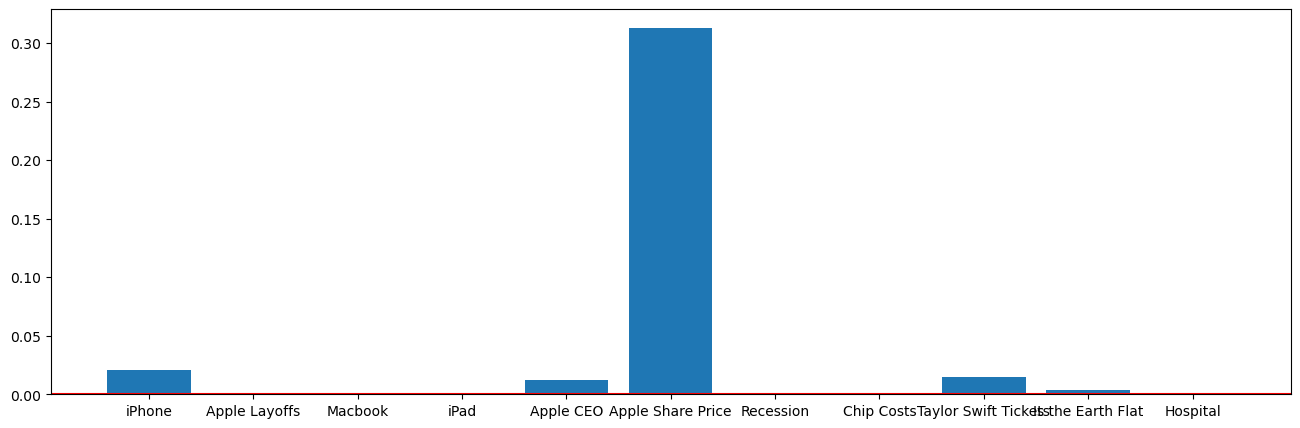

In [53]:
plt.figure(figsize = (16, 5))
plt.bar(range(len(coefficients)), coefficients, tick_label = X.columns)
plt.axhline(0., color = 'red')
plt.show()

In [54]:
coefficients

array([ 0.02032841,  0.        ,  0.        ,  0.        ,  0.01226284,
        0.31337405, -0.        , -0.        ,  0.01494808,  0.0035293 ,
        0.        ])

# 5.) Do these coefficient magnitudes make sense?

In summary, the coefficients make sense. The coefficients for relevant keywords are significantly different from zero and larger than those for irrelevant keywords.

1. **Relevance of Keywords to BasicEPS:**
   - The coefficients that are significantly different from zero correspond to keywords that are logically related to Apple's earnings per share (BasicEPS). For example, keywords directly related to Apple's products or financial performance (like "iPhone", "Macbook", "Apple Share Price") are more likely to have a meaningful impact on BasicEPS.
   - The coefficients for these relevant keywords are notably higher than for unrelated keywords (like "Taylor Swift Tickets", "Is the Earth Flat", "Hospital"), it suggests the model is capturing sensible relationships.

2. **Magnitude of Coefficients:**
    - Since we've scaled data using `StandardScaler`, the coefficients are based on these scaled values. This means the magnitudes are comparable across features, but they don't represent the impact of the original unscaled units.
   - The largest coefficient is `0.31337405`. If this coefficient corresponds to a keyword that is plausibly related to Apple's financial performance, its significant magnitude could indicate a strong relationship.
   - Small or zero coefficients for unrelated keywords suggest that the model correctly identifies these as poor predictors for BasicEPS, which is a good sign.

# 6.) Run a for loop looking at 10 different Lambdas and plot the coefficient magnitude for each.

# 7.) Run a cross validation. What is your ideal lambda?